In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from itertools import product

In [3]:
data = pd.read_csv("/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv")
print("data shape:", data.shape)
data.head()

data shape: (372450, 785)


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print("\n" + "="*60)
print("DATA CLEANING")
print("="*60)

# Check for missing values
print(f"Missing values before cleaning: {data.isnull().sum().sum()}")

# Remove any rows with missing values
data = data.dropna()
print(f"Missing values after cleaning: {data.isnull().sum().sum()}")

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"Duplicate rows found: {duplicates}")
if duplicates > 0:
    data = data.drop_duplicates()
    print(f"Duplicate rows removed: {duplicates}")

# Check data types
print(f"\nData types:\n{data.dtypes.value_counts()}")

# Check for any invalid pixel values (should be 0-255)
pixel_cols = data.columns[1:]  # All columns except label
invalid_pixels = ((data[pixel_cols] < 0) | (data[pixel_cols] > 255)).sum().sum()
print(f"Invalid pixel values (outside 0-255): {invalid_pixels}")

# Remove rows with invalid pixel values
if invalid_pixels > 0:
    mask = ((data[pixel_cols] >= 0) & (data[pixel_cols] <= 255)).all(axis=1)
    data = data[mask]
    print(f"Rows with invalid pixel values removed")

# Check for empty images (all zeros)
print(f"\nChecking for empty/uniform images...")
empty_images = (data[pixel_cols] == 0).all(axis=1).sum()
print(f"Empty images (all zeros): {empty_images}")
if empty_images > 0:
    data = data[~(data[pixel_cols] == 0).all(axis=1)]
    print(f"Empty images removed: {empty_images}")

# Check for uniform images (no contrast - all pixels same value)
uniform_images = data[pixel_cols].apply(lambda row: row.nunique() == 1, axis=1).sum()
print(f"Uniform images (no contrast): {uniform_images}")
if uniform_images > 0:
    data = data[~data[pixel_cols].apply(lambda row: row.nunique() == 1, axis=1)]
    print(f"Uniform images removed: {uniform_images}")

# Check for very low contrast images (std < 5)
low_contrast = (data[pixel_cols].std(axis=1) < 5).sum()
print(f"Very low contrast images (std < 5): {low_contrast}")
if low_contrast > 0:
    data = data[data[pixel_cols].std(axis=1) >= 5]
    print(f"Low contrast images removed: {low_contrast}")

# Check class distribution
print(f"\nClass distribution:")
print(data["0"].value_counts().sort_index())

# Ensure all classes (0-25) are present
expected_classes = set(range(26))
actual_classes = set(data["0"].unique())
missing_classes = expected_classes - actual_classes
if missing_classes:
    print(f"WARNING: Missing classes: {missing_classes}")
else:
    print("All 26 classes present ✓")

print(f"\nFinal cleaned data shape: {data.shape}")
print("="*60 + "\n")


DATA CLEANING
Missing values before cleaning: 0
Missing values after cleaning: 0
Duplicate rows found: 171355
Duplicate rows removed: 171355

Data types:
int64    785
Name: count, dtype: int64
Invalid pixel values (outside 0-255): 0

Checking for empty/uniform images...
Empty images (all zeros): 0
Uniform images (no contrast): 0
Very low contrast images (std < 5): 0

Class distribution:
0
0      7680
1      4804
2     12170
3      5430
4      6039
5      1147
6      3206
7      3974
8      1061
9      4593
10     3156
11     6226
12    10373
13     9909
14    29306
15    10087
16     3281
17     6170
18    24622
19    11698
20    14921
21     2616
22     5804
23     3557
24     5833
25     3432
Name: count, dtype: int64
All 26 classes present ✓

Final cleaned data shape: (201095, 785)



In [5]:
output = data["0"]
Input = data.drop(labels=["0"], axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(Input, output, test_size=0.2, random_state=42, stratify=output)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (160876, 784)
X_test shape: (40219, 784)


In [6]:
Y_train_raw = Y_train.copy()

In [7]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [8]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
print("x_train shape:", X_train.shape)
print("x_test shape:", X_test.shape)

x_train shape: (160876, 28, 28, 1)
x_test shape: (40219, 28, 28, 1)


In [9]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [10]:
Y_train = to_categorical(Y_train, num_classes=26)
Y_test = to_categorical(Y_test, num_classes=26)

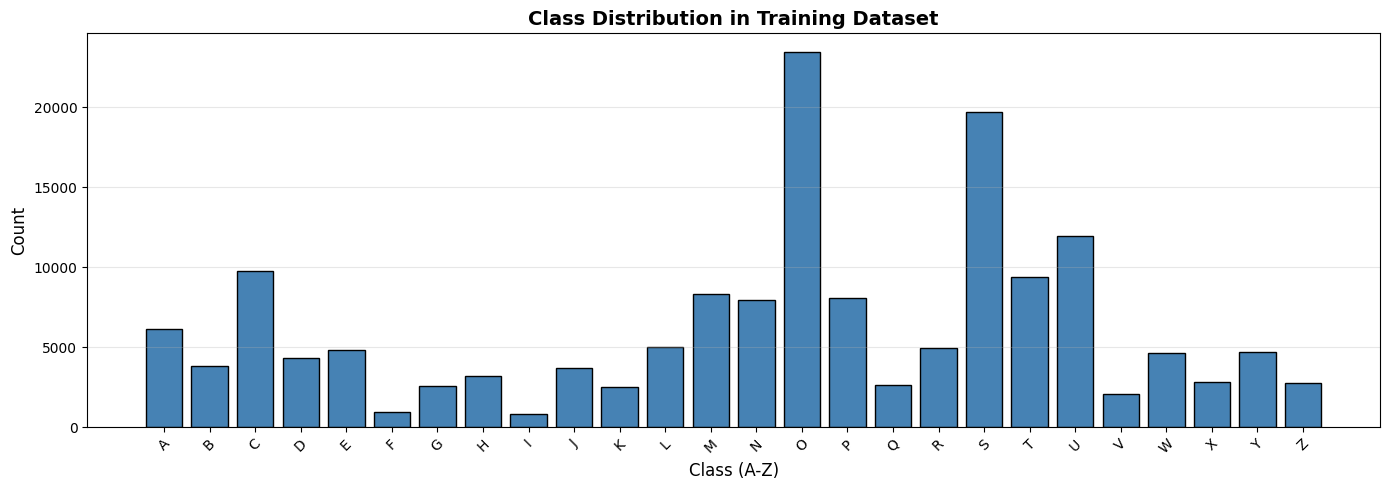

In [11]:
alpha = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
unique, counts = np.unique(Y_train_raw, return_counts=True)
plt.figure(figsize=(14, 5))
plt.bar(alpha, counts, color='steelblue', edgecolor='black')
plt.title('Class Distribution in Training Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Class (A-Z)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [12]:
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.15, random_state=2, stratify=Y_train.argmax(axis=1))
print("x_train shape", X_train.shape)
print("x_validation shape", X_validation.shape)
print("y_train shape", Y_train.shape)
print("y_validation shape", Y_validation.shape)

x_train shape (136744, 28, 28, 1)
x_validation shape (24132, 28, 28, 1)
y_train shape (136744, 26)
y_validation shape (24132, 26)


In [13]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.12),
    layers.RandomZoom(0.12),
    layers.RandomTranslation(0.12, 0.12),
    layers.RandomContrast(0.12)
], name="data_augmentation")

def preprocess_for_vgg(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.image.grayscale_to_rgb(image)
    return image, label

BATCH = 16

train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_ds = (
    train_ds.shuffle(10000)
            .map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
            .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH)
            .prefetch(tf.data.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((X_validation, Y_validation))
val_ds = (
    val_ds.map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH)
          .prefetch(tf.data.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_ds = (
    test_ds.map(preprocess_for_vgg, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(BATCH)
           .prefetch(tf.data.AUTOTUNE)
)

print("Training batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

I0000 00:00:1765135397.289094      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Training batches: 8547
Validation batches: 1509
Test batches: 2514


In [14]:
l2 = tf.keras.regularizers.l2(1e-4)
model = models.Sequential()

# Block 1
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2, input_shape=(224,224,3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Block 2
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Block 3
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Block 4
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Block 5
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3,3), activation='relu', padding='same', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))

# Fully Connected Layers
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='relu', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4096, activation='relu', kernel_regularizer=l2))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(26, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 512)    │         2,04

 Total params: 139,731,546 (533.03 MB)

 Trainable params: 139,704,154 (532.93 MB)

 Non-trainable params: 27,392 (107.00 KB)

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

In [16]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/10


I0000 00:00:1765135432.265721     123 service.cc:148] XLA service 0x7993a400fa20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765135432.266511     123 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765135434.517505     123 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/8547 ━━━━━━━━━━━━━━━━━━━━ 73:49:50 31s/step - accuracy: 0.0000e+00 - loss: 6.2519

I0000 00:00:1765135451.216975     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8547/8547 ━━━━━━━━━━━━━━━━━━━━ 2160s 249ms/step - accuracy: 0.7130 - loss: 2.8021 - val_accuracy: 0.9584 - val_loss: 1.6528 - learning_rate: 1.0000e-04
Epoch 2/10
8547/8547 ━━━━━━━━━━━━━━━━━━━━ 2108s 247ms/step - accuracy: 0.9161 - loss: 1.6948 - val_accuracy: 0.9686 - val_loss: 1.1860 - learning_rate: 1.0000e-04
Epoch 3/10
8547/8547 ━━━━━━━━━━━━━━━━━━━━ 2103s 246ms/step - accuracy: 0.9381 - loss: 1.2166 - val_accuracy: 0.9762 - val_loss: 0.9039 - learning_rate: 1.0000e-04
Epoch 4/10
8547/8547 ━━━━━━━━━━━━━━━━━━━━ 2104s 246ms/step - accuracy: 0.9453 - loss: 0.9681 - val_accuracy: 0.9770 - val_loss: 0.7583 - learning_rate: 1.0000e-04
Epoch 5/10
8547/8547 ━━━━━━━━━━━━━━━━━━━━ 2099s 246ms/step - accuracy: 0.9520 - loss: 0.8307 - val_accuracy: 0.9824 - val_loss: 0.6663 - learning_rate: 1.0000e-04
Epoch 6/10
8547/8547 ━━━━━━━━━━━━━━━━━━━━ 2108s 247ms/step - accuracy: 0.9554 - loss: 0.7422 - val_accuracy: 0.9738 - val_loss: 0.6473 - learning_rate: 1.0000e-04
Epoch 7/10
8547/8547 ━━━━━━━━━━━━

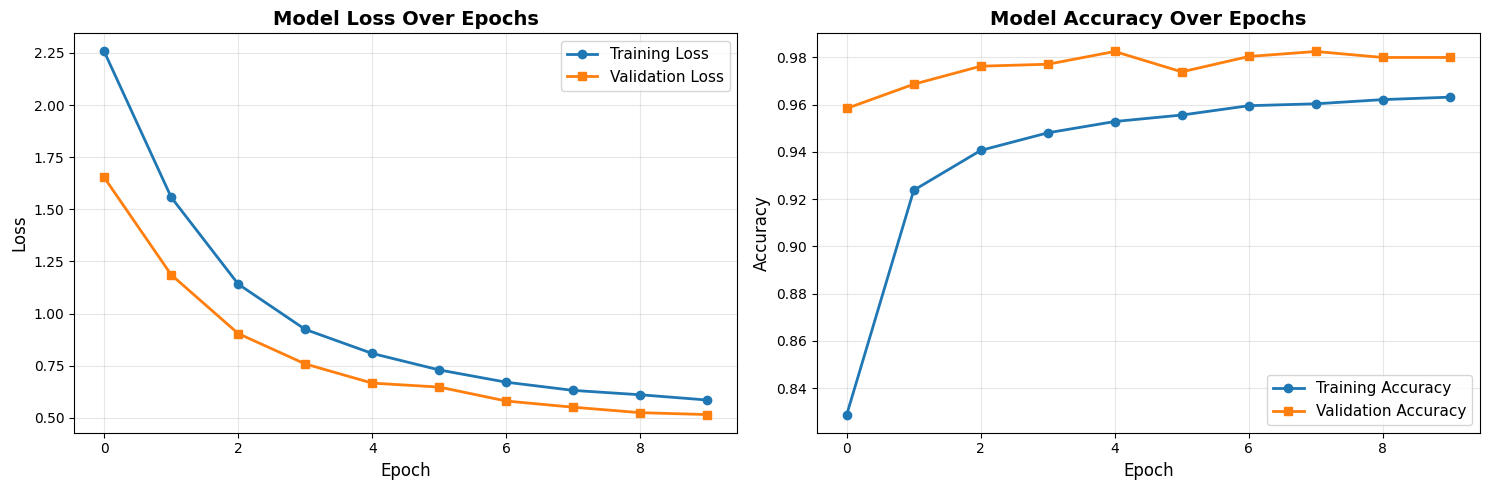

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2, marker='o')
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
axes[0].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
axes[1].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.argmax(np.vstack([y for x, y in test_ds]), axis=1)

2514/2514 ━━━━━━━━━━━━━━━━━━━━ 143s 56ms/step


In [19]:
accuracy = np.mean(y_pred == y_true)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\n" + "="*50)
print("EVALUATION METRICS")
print("="*50)
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")
print("="*50)


EVALUATION METRICS
Accuracy : 0.9779
Precision: 0.9713
Recall   : 0.9796
F1-score : 0.9749


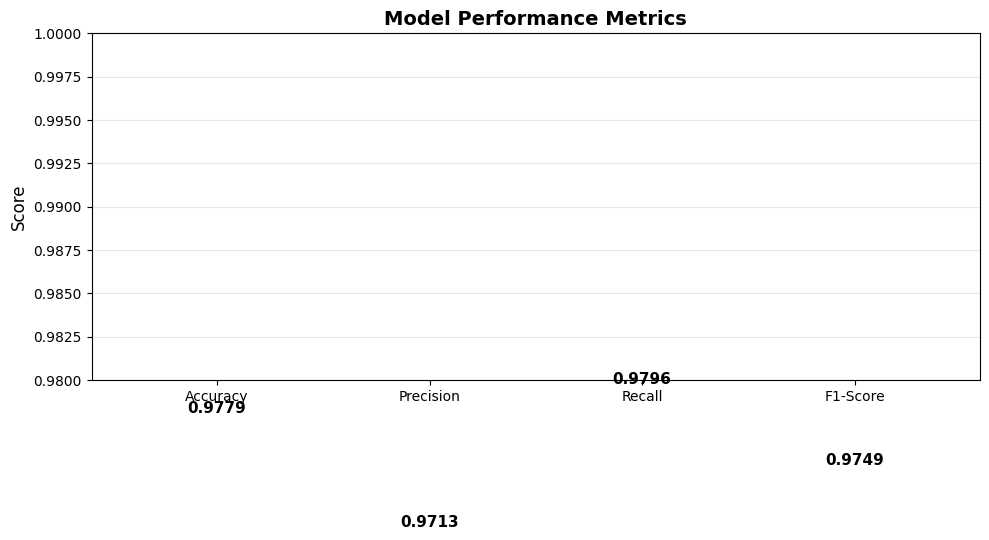

In [20]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors, edgecolor='black', linewidth=2)
plt.ylim([0.98, 1.0])
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

for bar, value in zip(bars, values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [21]:
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred))


DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1536
           1       0.88      0.99      0.93       961
           2       0.99      0.99      0.99      2434
           3       0.80      0.97      0.87      1086
           4       0.97      0.99      0.98      1208
           5       0.98      0.98      0.98       229
           6       0.97      0.98      0.97       641
           7       0.94      0.99      0.96       795
           8       0.99      0.98      0.98       212
           9       0.96      0.98      0.97       919
          10       0.98      0.95      0.97       631
          11       0.99      0.98      0.98      1245
          12       0.99      1.00      0.99      2075
          13       0.99      0.97      0.98      1982
          14       1.00      0.94      0.97      5861
          15       0.99      0.99      0.99      2017
          16       0.98      0.96      0.97     

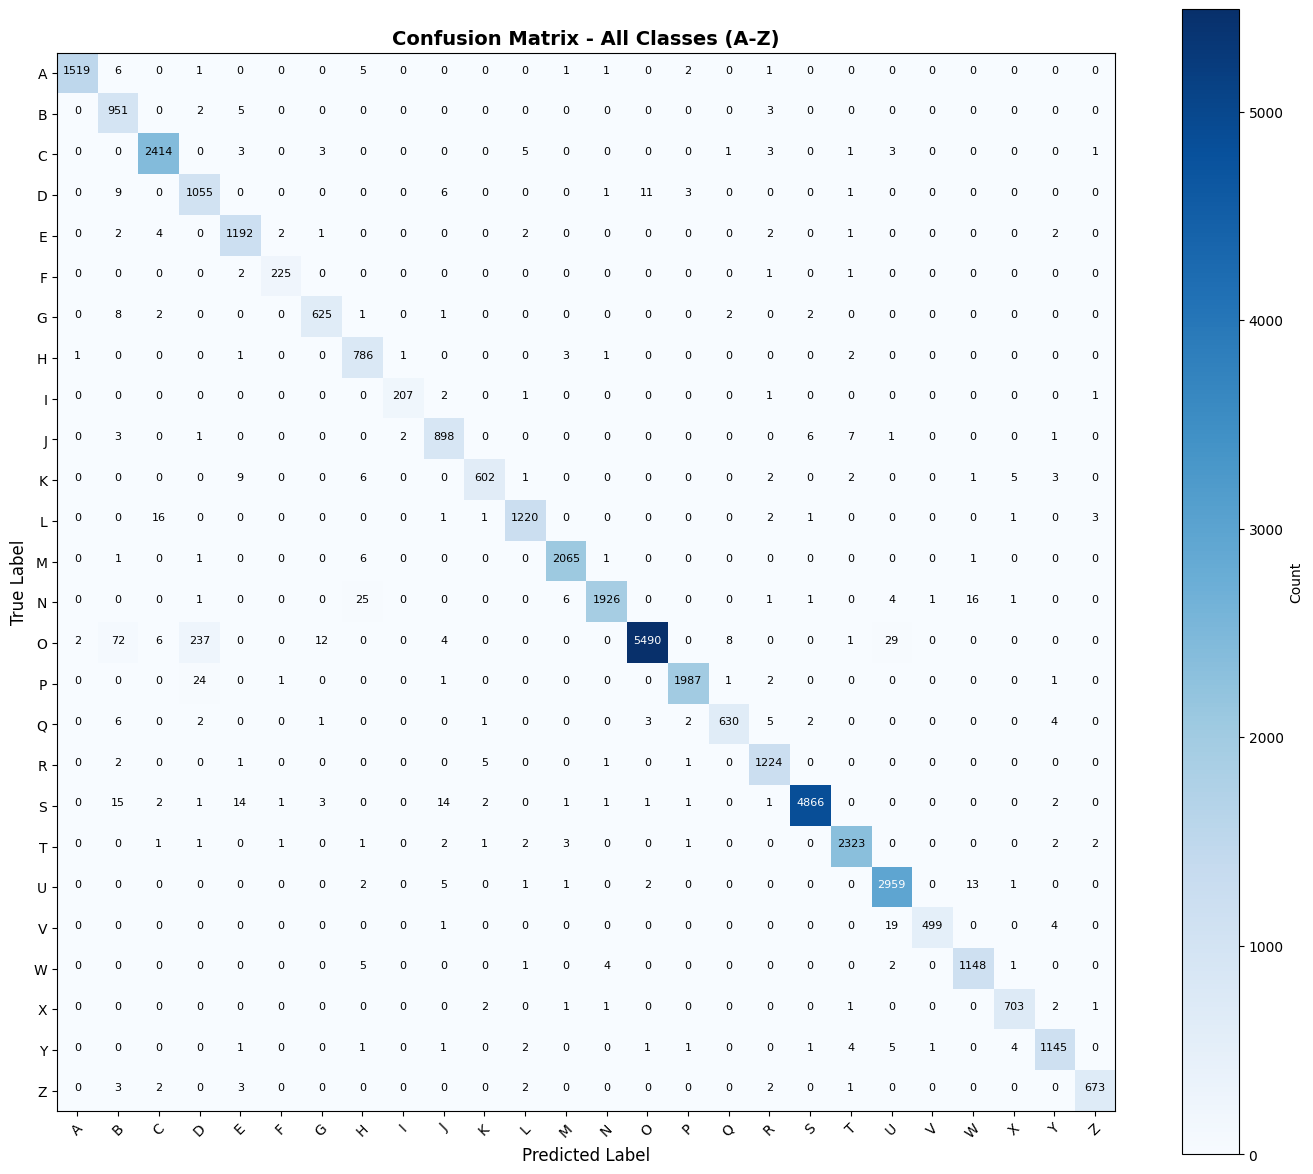

In [22]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix - All Classes (A-Z)", fontsize = 14, fontweight='bold')
plt.colorbar(label='Count')

classes = [chr(i) for i in range(65, 91)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black",
             fontsize=8)

plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.tight_layout()
plt.show()

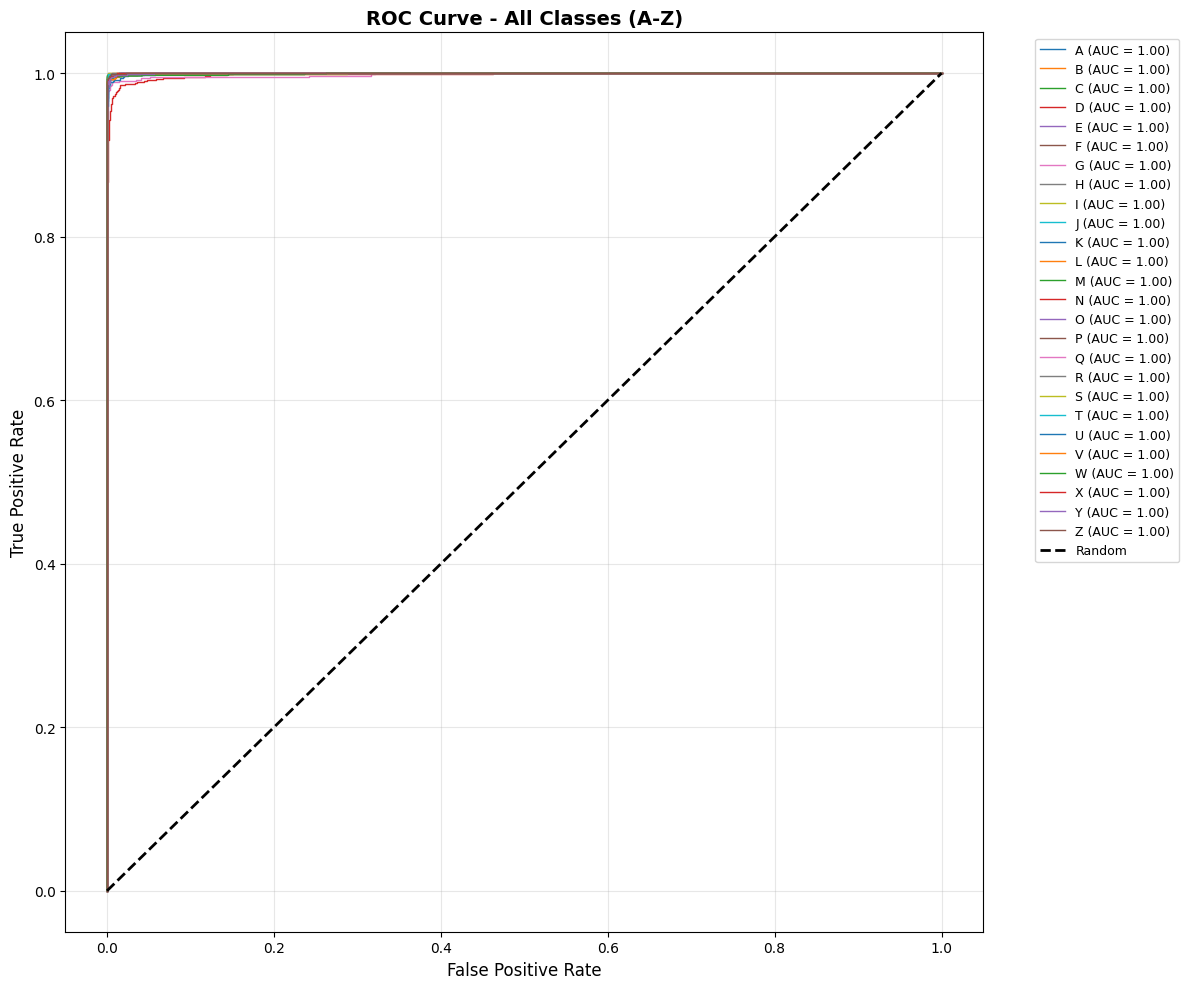

In [23]:
fpr = {}
tpr = {}
roc_auc = {}

y_true_onehot = np.zeros((len(y_true), 26))
for i, label in enumerate(y_true):
    y_true_onehot[i, label] = 1

for i in range(26):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
for i in range(26):
    plt.plot(fpr[i], tpr[i], lw=1, label=f'{chr(65+i)} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Random')
plt.title("ROC Curve - All Classes (A-Z)", fontsize=14, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()